## 读书笔记：强化学习（第1版）（英文）
### Reinforcement Learning: An Introduction

### 原书链接
* [纸质书购买](https://www.amazon.com/Reinforcement-Learning-Introduction-Adaptive-Computation/dp/0262193981)
* [官方免费电子版下载（注意这是第2版，并且是非正式版）](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)

### 主要内容
#### 第一章：[介绍（Introduction）](#introduction)
#### 第二章：[评价性反馈（Evaluative Feedback）](#feedback)
#### 第三章：[强化学习问题（The Reinforcement Learning Problem）](#problem)
#### 第四章：[动态规划（Dynamic Programming）](#dp)
#### 第五章：[蒙特卡罗方法（Monte Carlo Methods）](#mc)
#### 第六章：[时序差分学习（Temporal-Difference Learning）](#td)
#### 第七章：[资格迹（Eligibility Traces）](#et)
#### 第八章：泛化与函数近似（Generalization and Function Approximation），待定
#### 第九章：规划与学习（Planning and Learning），待定
#### 第十章：强化学习维度（Dimensions of Reinforcement Learning），待定
#### 第十一章：举例分析（Case Studies），待定

### 笔记功能
本读书笔记并不是原书的摘要版。如果想要对强化学习做系统地了解，本人建议直接阅读原书。本读书笔记的作用在于：
* 推导书中的一些数学结论；
* 梳理本人感兴趣的主要内容，以做记录。

### 更新记录
* 01/24/2019 - 完成第二章：评价性反馈
* 01/25/2019 - 完成第三、四章：强化学习问题和动态规划
* 01/26/2019 - 完成第五、六章：蒙特卡罗方法和时序差分学习
* 01/29/2019 - 完成第七章：资格迹

### <a id='introduction'></a>1 介绍（Introduction）

强化学习定义的两大要点：
* 与环境交互
* 以目标为导向

### <a id='feedback'></a>2 评价性反馈（Evaluative Feedback）

#### $n$-摇臂赌博机问题
这是最简化的强化学习问题设定：面对一个摇臂机（只有一个状态），需要选出期望奖励最多的摇臂（选择最优的动作）。

解决这一问题分两步：
1. 估计动作的价值：估计各个摇臂的期望奖励；
2. 选择动作：基于对价值的估计来选择摇臂。

估计价值：

$$Q_t(a)=(r_1+r_2+...+r_{k_a})/k_a$$

选择动作：
1. 贪心选择法（只选择当前估价最高的动作）
2. $\varepsilon$-贪心选择法（以$\varepsilon$的概率探索新的动作，$1-\varepsilon$的概率选择当前估价最高的动作）
3. Softmax选择法（选择各个动作的概率为：$p(a)=e^{Q_t(a)/\tau}/\sum_{b=1}^{n}e^{Q_t(b)/\tau}$）

下面求解2.2节的摇臂赌博机问题。

In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')
sns.set_style({'font.sans-serif':['simhei','Arial']}) #图中显示中文

In [2]:
def action_selection(method, exp_rate, step_size=None, initial_value=0,
                     levers=10, tasks=2000, plays=1000, true_value_variance=1,
                     reward_variance=1):
    """
    Solve n-armed bandit problem.

    Parameters
    ----------
    method:
        str, action selection rule, available values: 'epsilon' or 'softmax'.
    exp_rate:
        float, exploring rate.
        If the method is 'epsilon': probability of selecting an action at random, 
        uniformly, independently of the action-value estimates. Between 0 and 1.
        If the method is 'softmax': temperature in Gibbs distribution. Greater than 0.
    step_size:
        None for sample-average method for value estimate, a constant between 0 and 1.
    initial_value:
        float, initial guess of value estimate.
    levers:
        int, equal or greater than 2, number of lever of one-armed bandit. Default is 10.
    tasks:
        int, equal or greater than 1, number of one-armed bandit machine. Default is 2000.
    plays:
        int, equal or greater than 1, number of play (run). Default is 1000.
        For each play, we will play one of the machine's levers for all machines.
    true_value_variance:
        float, variance of the normal distribution for true values for n-armed bandit.
        Default is 1.0.
    reward_variance:
        float, variance of the normal distribution of rewards for each action.
        Default is 1.0.

    Returns
    -------
    avg_reward:
        list, length is equal to the number of plays,
        and each value corresponds to the average reward of all machines for that play.
    optimal_action_ratio:
        list, length is equal to the number of plays,
        and each value corresponds to the ratio of correctly selecting optimal action
        of all machines for that play.
    """

    #true (actual) values of each action, each column is an n-armed bandit
    Q_star = np.random.normal(size=(levers, tasks), loc=0.0, scale=np.sqrt(true_value_variance))
    # optimal actions for each n-armed bandit
    optimal_action = np.argmax(Q_star, axis=0) 
    # value estimates of each action
    Q = initial_value*np.ones(shape=(levers, tasks))
    # count actions
    acc_action = np.zeros(shape=(levers, tasks))
    # average reward of each play by averaging the rewards of all tasks for that play
    avg_reward = []
    # the ratio of actions equal to optiaml actions at that play
    optimal_action_ratio = []

    # loop over each play
    for play in range(1, plays + 1):

        # reward for each task
        machine_reward = []
        # action for each task
        machine_action = []

        for machine in range(0, tasks):

            # For first play, select actions randomly
            if play == 1:
                action = np.random.choice(range(0, levers))
            else:
                if method == 'epsilon':
                    r = np.random.random()
                    if r > exp_rate:
                        # select action with highest value estimate, exploitation
                        action = np.random.choice(
                            np.argwhere(Q[:, machine] == np.max(Q[:, machine])).reshape(-1))
                    else:
                        # exploration
                        action = np.random.choice(range(0, levers))
                elif method == 'softmax':
                    action = np.random.choice(
                        range(0, levers),
                        p=np.exp(Q[:, machine]/exp_rate)/np.sum(np.exp(Q[:, machine]/exp_rate)))

            reward = np.random.normal(loc=Q_star[action, machine], scale=np.sqrt(reward_variance))
            acc_action[action, machine] += 1

            # incremental update formula: update value estimates
            if step_size == None:
                Q[action, machine] = Q[action, machine] + 1/acc_action[action, machine]*(reward-Q[action, machine])
            else:
                Q[action, machine] = Q[action, machine] + step_size*(reward-Q[action, machine])

            machine_action.append(action)
            machine_reward.append(reward)

        optimal_action_ratio.append(np.mean(machine_action == optimal_action))
        avg_reward.append(np.mean(machine_reward))
        
    return avg_reward, optimal_action_ratio

#### $\varepsilon$-贪心选择法

In [3]:
# epsilon greedy action selection
plays = 1000
e0_reward, e0_action = action_selection(method='epsilon', exp_rate=0, plays=plays)
e0p01_reward, e0p01_action = action_selection(method='epsilon', exp_rate=0.01, plays=plays)
e0p1_reward, e0p1_action = action_selection(method='epsilon', exp_rate=0.1, plays=plays)

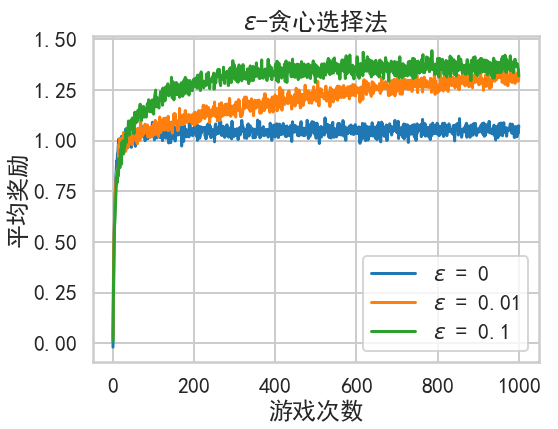

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, plays + 1), e0_reward, label='$\epsilon$ = 0')
plt.plot(range(1, plays + 1), e0p01_reward, label='$\epsilon$ = 0.01')
plt.plot(range(1, plays + 1), e0p1_reward, label='$\epsilon$ = 0.1')

plt.xlabel('游戏次数')
plt.ylabel('平均奖励')
plt.legend()
plt.title('$\epsilon$-贪心选择法');

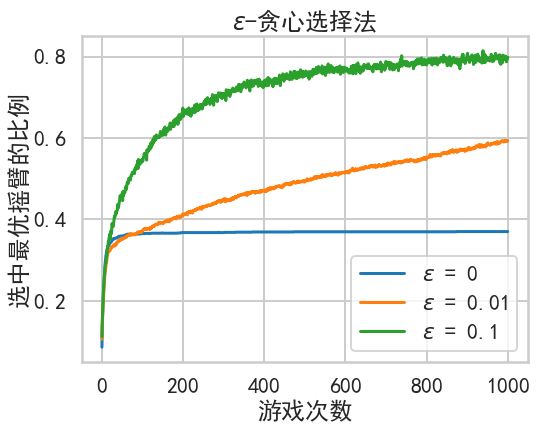

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, plays + 1), e0_action, label='$\epsilon$ = 0')
plt.plot(range(1, plays + 1), e0p01_action, label='$\epsilon$ = 0.01')
plt.plot(range(1, plays + 1), e0p1_action, label='$\epsilon$ = 0.1')

plt.xlabel('游戏次数')
plt.ylabel('选中最优摇臂的比例')
plt.legend()
plt.title('$\epsilon$-贪心选择法');

#### Softmax选择法

In [4]:
# softmax action selection
plays = 1000

et0p01_reward, et0p01_action = action_selection(method='softmax', exp_rate=0.01, plays=plays)
et0p1_reward, et0p1_action = action_selection(method='softmax', exp_rate=0.1, plays=plays)
et1_reward, et1_action = action_selection(method='softmax', exp_rate=1, plays=plays)

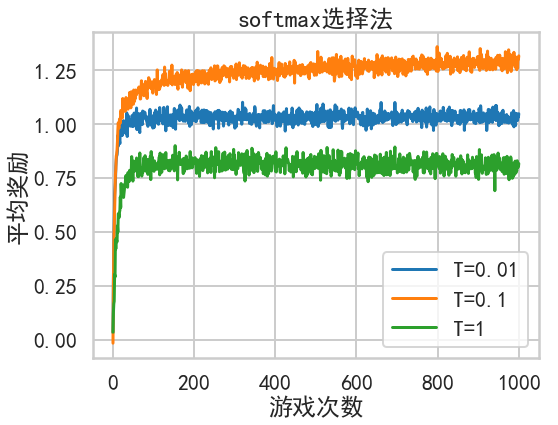

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, plays + 1), et0p01_reward, label='T=0.01')
plt.plot(range(1, plays + 1), et0p1_reward, label='T=0.1')
plt.plot(range(1, plays + 1), et1_reward, label='T=1')

plt.xlabel('游戏次数')
plt.ylabel('平均奖励')
plt.legend()
plt.title('softmax选择法');

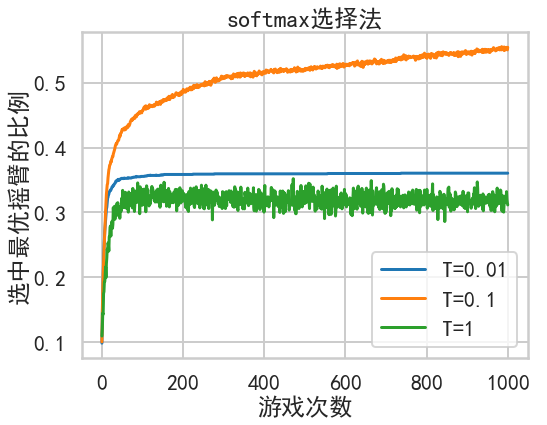

In [39]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, plays + 1), et0p01_action, label='T=0.01')
plt.plot(range(1, plays + 1), et0p1_action, label='T=0.1')
plt.plot(range(1, plays + 1), et1_action, label='T=1')

plt.xlabel('游戏次数')
plt.ylabel('选中最优摇臂的比例')
plt.legend()
plt.title('softmax选择法');

#### 价值估计递增表达式

$$Q_{k+1}=Q_{k}+\frac{1}{k+1}[r_{k+1}-Q_k]$$

采用常数步长的价值估计递增表达式为：

$$Q_{k+1}=Q_k+\alpha[r_{k+1}-Q_k]$$

注意：使用这一公式对$Q$所做的估计不会收敛，但这恰好适用于非稳定目标问题。非稳定目标问题是强化学习中最常见的情况，因此通常使用的都是这一递增公式。

### <a id='problem'></a>3 强化学习问题（The Reinforcement Learning Problem）

累积奖励：
$$R_t=\sum_{k=0}^T\gamma^kr_{t+k+1}$$

马尔可夫性质：
$$Pr\{s_{t+1}=s',r_{t+1}=r|s_t,a_t,r_t,s_{t-1},a_{t-1},…,r_1,s_0,a_0\}=Pr\{s_{t+1}=s',r_{t+1}=r|s_t,a_t\}$$

状态转移概率：
$$P_{ss'}^a=Pr\{s_{t+1}=s'|s_t=s,a_t=a\}$$

即刻奖励期望：
$$R_{ss'}^a=E\{r_{t+1}|s_t=s,a_t=a,s_{t+1}=s'\}$$

价值函数

状态价值函数：
$$V^\pi(s)=E_\pi\{R_t|s_t=s\}=E_\pi\{\sum_{k=0}^\infty\gamma^kr_{t+k+1}|s_t=s\}$$
动作价值函数
$$Q^\pi(s,a)=E_\pi\{R_t|s_t=s,a_t=a\}=E_\pi\{\sum_{k=0}^\infty\gamma^kr_{t+k+1}|s_t=s,a_t=a\}$$
这两者的关系为：
$$V^\pi(s)=\sum_a\pi(s,a)Q^\pi(s,a)$$


几乎所有的强化学习算法都是在讲如何对价值函数进行估计。

另外，价值函数指的是对应某一策略的价值函数。

#### Bellman等式

$$V^\pi(s)=\sum_a\pi(s,a)\sum_{s'}P_{ss'}^a[R_{ss'}^a+\gamma V^\pi(s')]$$

对Bellman等式进行推导

$$
V^{\pi}(s)=E_{\pi}\{R_t|s_t=s\}=\sum_a\pi(s,a)\sum_{s'}P_{ss'}^aE\{R_t|s_t=s,a_t=a,s_{t+1}=s'\}
$$

$$
\begin{align}
E\{R_t|s_t=s,a_t=a,s_{t+1}=s'\}
&=E\{\sum_{k=0}^{\infty}\gamma^kr_{t+k+1}|s_t=s,a_t=a,s_{t+1}=s'\}\\
&=E\{r_{t+1}+\gamma\sum_{k=0}^{\infty}\gamma^kr_{t+k+2}|s_t=s,a_t=a,s_{t+1}=s'\}\\
&=R_{ss'}^a+\gamma E\{\sum_{k=0}^{\infty}\gamma^kr_{t+1+k+1}|s_t=s,s_{t+1}=s',a_t=a\}\\
&=R_{ss'}^a+\gamma E\{\sum_{k=0}^{\infty}\gamma^kr_{t+1+k+1}|s_{t+1}=s'\}（这一步应用了马尔可夫性质）\\
&=R_{ss'}^a+\gamma E_{\pi}\{\sum_{k=0}^{\infty}\gamma^kr_{t+1+k+1}|s_{t+1}=s'\}\\
&=R_{ss'}^a+\gamma E_{\pi}\{R_{t+1}|s_{t+1}=s'\}\\
&=R_{ss'}^a+\gamma V^{\pi}(s')
\end{align}
$$

所以
$$V^{\pi}(s)=\sum_a\pi(s,a)\sum_{s'}P_{ss'}^a[R_{ss'}^a+\gamma V^{\pi}(s')]$$

练习题3.8：求动作价值函数的Bellman等式。

$$
\begin{align}
Q^{\pi}(s,a)=E_{\pi}\{R_t|s_t=s,a_t=a\}
&=\sum_{s'}P_{ss'}^aE\{R_t|s_t=s,a_t=a,s_{t+1}=s'\}\\
&=\sum_{s'}P_{ss'}^aE\{r_{t+1}+\gamma\sum_{k=0}^{\infty}\gamma^kr_{t+k+2}|s_t=s,a_t=a,s_{t+1}=s'\}\\
&=\sum_{s'}P_{ss'}^a\{R_{ss'}^a+\gamma E_{\pi}[\sum_{k=0}^{\infty}\gamma^kr_{t+1+k+1}|s_{t+1}=s']\}\\
&=\sum_{s'}P_{ss'}^a[R_{ss'}^a+\gamma V^{\pi}(s')]\\
&=\sum_{s'}P_{ss'}^a[R_{ss'}^a+\gamma\sum_{a'}\pi(s',a')Q^{\pi}(s',a')]\\
\end{align}
$$

#### 最优Bellman等式

$$
V^{\ast}(s)=\max_{a\in A(s)}Q^{{\pi}^{\ast}}(s,a)=\max_a\sum_{s'}P_{ss'}^a[R_{ss'}^a+\gamma V^{\ast}(s')]
$$
$$
Q^{\ast}(s,a)=\sum_{s'}P_{ss'}^a[R_{ss'}^a+\gamma\max_{a'}Q^{\ast}(s',a')]
$$


强化学习问题求解的过程就是找到最优Bellman等式的解，通常来说是近似解，然后利用价值函数来确定最优策略。

### <a id='dp'></a>4 动态规划（Dynamic Programming）

动态规划为有模型算法，意思是状态转移概率和即刻奖励期望这些与环境相关的值已知。

#### 策略评价（Policy Evaluation）

利用Bellman等式，通过迭代的方式计算某一策略的状态价值函数
$$V_{k+1}(s)=\sum_a\pi(s,a)\sum_{s'}P_{ss'}^a[R_{ss'}^a+\gamma V_k(s')]$$

#### 策略改进（Policy Improvement）
$$\pi'(s)=\arg\max_a\sum_{s'}P_{ss'}^a[R_{ss'}^a+\gamma V^{\pi}(s')]$$

#### 策略迭代（Policy Iteration）
完成策略评价步骤后，再进行策略改进步骤，循环这两个步骤，以至最优。

#### 价值迭代（Value Iteration）

合并策略评价和策略改进为一体

$$V_{k+1}(s)=\max_a\sum_{s'}P_{ss'}^a[R_{ss'}^a+\gamma V_k(s')]$$

价值迭代也可以看做是把最优Bellman等式变成递增公式。

### <a id='mc'></a>5 蒙特卡罗方法（Monte Carlo Methods）

蒙特卡罗方法为无模型算法，意味着状态转移概率和即刻奖励期望这些与环境相关的值未知。因此，蒙特卡罗方法只能对价值函数进行采样估计。

蒙特卡罗方法对价值估计的更新是在完成一个采样轨迹（episode）之后。

蒙特卡罗方法对以下状态价值函数表达式进行采样估计：

$$V(s)=E_{\pi}\{R_t|s_t=s\}$$

采用常数步长的递增表达式为：

$$V(s_t)\leftarrow V(s_t)+\alpha[R_t-V(s_t)]$$

因为无模型算法中状态转移概率和即刻奖励期望未知，因此仅对$V^{\pi}(s)$进行估计是不够的，最主要的还是对$Q^{\pi}(s,a)$进行估计。


预测问题：求得价值函数。

控制问题：通过对价值函数进行估计确定最优策略。

#### 蒙特卡罗控制

蒙特卡罗控制需要确保持续地探索，使得所有的状态-动作对都能被充分地估计：

* 同策略蒙特卡罗算法：$\epsilon$-贪心策略

* 异策略蒙特卡罗算法

### <a id='td'></a>6 时序差分学习（Temporal-Difference Learning）

时序差分（TD）学习为无模型算法，意味着状态转移概率和即刻奖励期望这些与环境相关的值未知。因此，TD学习只能对价值函数进行采样估计。

TD学习对价值估计的更新是在下一个时间节点。

TD(0)对以下状态价值函数表达式进行采样估计：

$$V^{\pi}(s)=E_{\pi}\{r_{t+1}+\gamma\sum_{k=0}^{\infty}\gamma^kr_{t+k+2}|s_t=s\}=E_{\pi}\{r_{t+1}+\gamma V^{\pi}(s_{t+1})|s_t=s\}$$

采用常数步长的递增表达式为：

$$V(s_t)\leftarrow V(s_t)+\alpha[r_{t+1}+\gamma V(s_{t+1})-V(s_t)]$$

与蒙特卡罗方法相同，时序差分学习也需要对$Q_{\pi}(s,a)$进行估计。

#### Sarsa：同策略TD控制

$$Q(s_t,a_t)\leftarrow Q(s_t,a_t )+\alpha[r_{t+1}+\gamma Q(s_{t+1},a_{t+1})-Q(s_t,a_t)]$$

#### Q-学习：异策略TD控制

$$Q(s_t,a_t)\leftarrow Q(s_t,a_t)+\alpha[r_{t+1}+\gamma \max_a ⁡Q(s_{t+1},a)-Q(s_t,a_t)]$$

Q-学习也可以看做是对最优Bellman等式中的$Q^{\ast}(s,a)$的直接估计。

### <a id='et'></a>7 资格迹（Eligibility Traces）

两种理解资格迹的等价视角

* 前向视角（forward view）：用来理解资格迹算法到底在计算什么，从理论上把TD学习和蒙特卡罗方法联系起来。
* 反向视角（backward view）：实际使用的资格迹算法

#### $TD(\lambda)$的前向视角

$n$步$TD$预测

$$R_t^{(n)}=r_{t+1}+\gamma r_{t+2}+\gamma^2 r_{t+3}+...+\gamma^{n-1} r_{t+n}+\gamma^n V_t(s_{t+n})$$

$n=1$时，为TD(0)；$n=\infty$时，为蒙特卡罗方法。

$TD(\lambda)$：对$n$步$TD$预测$R_t^{(n)}$进行加权平均

$$R_t^\lambda =(1-\lambda)\sum_{n=1}^\infty\lambda^{n-1}R_t^{(n)}=(1-\lambda)\sum_{n=1}^{T-t-1}\lambda^{n-1}R_t^{(n)}+\lambda^{T-t-1}R_t$$

$$\Delta V_t(s_t)=\alpha[R_t^\lambda-V_t(s_t)]$$

#### $TD(\lambda)$的反向视角

资格迹：

\begin{equation}
   e_t(s) = \left\{
   \begin{array}
     \gamma\lambda e_{t-1}(s) & s \neq s_t \\
     \gamma\lambda e_{t-1}(s)+1 & s=s_t \\
   \end{array}
   \right.
\end{equation}

$$\delta_t=r_{t+1}+\gamma V_t(s_{t+1})-V_t(s_t)$$

$$\Delta V_t(s_t)=\alpha\delta_te_t(s)$$

两种视角等价：

$$\sum_{t=0}^{T-1}\Delta V_t^{TD}(s)=\sum_{t=0}^{T-1}\Delta V_t^\lambda(s_t)I_{ss_t}$$

证明：

首先用数学归纳法证明资格迹可以表示为：

$$e_t(s)=\sum_{k=0}^t(\gamma\lambda)^{t-k}I_{ss_k}$$

当$t=0$时，由资格迹的定义可知$e_t(s)=I_{ss_0}$，满足上述等式。

当$t=1$时，由资格迹的定义可知$e_t(s)=\gamma\lambda I_{ss_0}I_{s\neq s_1}+(\gamma\lambda I_{ss_0}+1)I_{ss1}=\gamma\lambda I_{ss_0} (I_{ss_1}+ I_{s\neq s_1})+I_{ss1}=\gamma\lambda I_{ss_0}+I_{ss1}$，满足上述等式。

假设对任意$t\geqslant1$，$e_t(s)=\sum_{k=0}^t(\gamma\lambda)^{t-k}I_{ss_k}$。那么对于$e_{t+1}(s)$，由资格迹的定义可知，

$$
\begin{align}
e_{t+1}(s)
&=\gamma\lambda e_t(s)I_{s\neq s_{t+1}}+(\gamma\lambda e_t(s)+1)I_{ss_{t+1}}\\
&=\gamma\lambda e_t(s)(I_{s\neq s_{t+1}}+I_{ss_{t+1}})+I_{ss_{t+1}}\\
&=\gamma\lambda e_t(s)+I_{ss_{t+1}}\\
&=\gamma\lambda \sum_{k=0}^t(\gamma\lambda)^{t-k}I_{ss_k}+I_{ss_{t+1}}\\
&=\sum_{k=0}^t(\gamma\lambda)^{t+1-k}I_{ss_k}+I_{ss_{t+1}}\\
&=\sum_{k=0}^{t+1}(\gamma\lambda)^{t+1-k}I_{ss_k}\\
\end{align}
$$

所以对于任意$t\geqslant0$，均有$e_t(s)=\sum_{k=0}^t(\gamma\lambda)^{t-k}I_{ss_k}$。

对于双重求和，有：

$$
\begin{align}
\sum_{k=0}^{T-1}\sum_{t=0}^k
&=(\sum_{k=t}^{T-1}+\sum_{k=0}^{t-1})(\sum_{t=0}^{T-1}-\sum_{t=k+1}^{T-1})\\
&=\sum_{k=t}^{T-1}\sum_{t=0}^{T-1}-\sum_{k=t}^{T-1}\sum_{t=k+1}^{T-1}+\sum_{k=0}^{t-1}\sum_{t=0}^k\\
\end{align}
$$

其中后面两项都为零。以第二项为例。由求和上下限的定义可得，$k\geqslant t$及$t\geqslant k+1$，而这两个不等式是矛盾的，所以此求和为零。最后一项以此类推。

所以

$$\sum_{k=0}^{T-1}\sum_{t=0}^k=\sum_{k=t}^{T-1}\sum_{t=0}^{T-1}=\sum_{t=0}^{T-1}\sum_{k=t}^{T-1}$$

所以

$$
\begin{align}
\sum_{t=0}^{T-1}\Delta V_t^{TD}(s)
&=\sum_{t=0}^{T-1}\alpha\delta_t\sum_{k=0}^t(\gamma\lambda)^{t-k}I_{ss_k}\\
&=\sum_{k=0}^{T-1}\alpha\sum_{t=0}^k(\gamma\lambda)^{k-t}I_{ss_t}\delta_k (交换t和k)\\
&=\sum_{t=0}^{T-1}\alpha\sum_{k=t}^{T-1}(\gamma\lambda)^{k-t}I_{ss_t}\delta_k\\
&=\sum_{t=0}^{T-1}\alpha I_{ss_t}\sum_{k=t}^{T-1}(\gamma\lambda)^{k-t}\delta_k
\end{align}
$$

后面证明参照原书。

#### Sarsa($\lambda$)

$$Q_{t+1}(s,a)=Q_t(s,a)+\alpha\delta_te_t(s,a)$$

$$\delta_t=r_{t+1}+\gamma Q_t(s_{t+1},a_{t+1})-Q_t(s_t,a_t)$$

$$
\begin{equation}
   e_t(s,a) = \left\{
   \begin{array}
     \gamma\lambda e_{t-1}(s,a)+1 & s=s_t,a=a_t \\
     \gamma\lambda e_{t-1}(s,a) & 其他 \\
   \end{array}
   \right.
\end{equation}
$$

#### Watkin’s Q($\lambda$)

$$
\begin{equation}
   e_t(s,a)=I_{ss_t}\cdot I_{aa_t}+ = \left\{
   \begin{array}
     \gamma\lambda e_{t-1}(s,a) &当 Q_{t-1}(s_t,a_t)=\max_aQ_{t-1}(s_t,a) \\
     0 & 其他 \\
   \end{array}
   \right.
\end{equation}
$$

$$Q_{t+1}(s,a)=Q_t(s,a)+\alpha\delta_te_t(s,a)$$

$$\delta_t=r_{t+1}+\gamma\max_{a'}Q_t(s_{t+1},a')-Q_t(s_t,a_t)$$